In [1]:
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from fact.io import read_h5py
from matplotlib import pyplot as plt
plt.style.use('msackel')

exec(open('/home/msackel/Desktop/gammaClassification/programm/theta_cut/theta_cut.py').read())
exec(open('/home/msackel/Desktop/gammaClassification/programm/model_significance/model_significance.py').read())

xgbc = XGBClassifier(
				max_depth= 1,
				learning_rate= 0.5,
				n_estimators= 100,
				booster= 'gbtree', 
				gamma= 0.5,
				n_jobs= 15,
				reg_lambda= 0.1,
				subsample= 0.20,
				eval_metric= 'auc'
				)

Tree = RandomForestClassifier(
				max_depth=15, 
				max_features=7, 
				criterion='entropy', 
				n_estimators=100, 
				n_jobs=25
				)


with open('/home/msackel/Desktop/gammaClassification/config/feature.yaml') as f:
		feature = yaml.load(f)

eval_data = pd.read_hdf('/home/msackel/Desktop/gammaClassification/data/raw_data/proton_precuts.hdf5')[feature]

print('---Theta**2 = 0.5')
train_Tree= theta_cut('/home/msackel/Desktop/gammaClassification/data/raw_data/gamma_precuts.hdf5', 
				'/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5', 0.5) 
train_XGBC= theta_cut('/home/msackel/Desktop/gammaClassification/data/raw_data/gamma_precuts.hdf5', 
				'/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5', 0.1) 
xgbc.fit(train_XGBC.drop('label', axis=1), train_XGBC.label)
Tree.fit(train_Tree.drop('label', axis=1), train_Tree.label)

---Theta**2 = 0.5


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=25, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [2]:
stack_data = pd.read_pickle('/home/msackel/Desktop/gammaClassification/data/dataSimu')
stack_data = pd.concat([stack_data.query('label ==1')[:20000],stack_data.query('label ==0')[:100000]])
pred_tree = Tree.predict_proba(stack_data.drop('label', axis=1))[:,1]
pred_xgbc = xgbc.predict_proba(stack_data.drop('label', axis=1))[:,1]

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


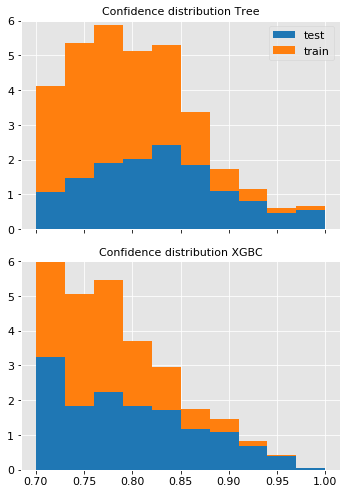

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.title('Confidence distribution Tree')
plt.hist([pred_tree[stack_data['label']==1], pred_tree[stack_data['label']==0]], label=['test', 'train'], stacked=True, normed=True, bins=10, range=[0.7,1])
plt.setp(ax1.get_xticklabels(), visible=False) # make these tick labels invisible
plt.legend()
plt.ylim(0,6)

ax2 = fig.add_subplot(212, sharex=ax1)
plt.title('Confidence distribution XGBC')
plt.hist([pred_xgbc[stack_data['label']==1], pred_xgbc[stack_data['label']==0]], stacked=True, normed=True, bins=10, range=[0.7,1])
plt.ylim(0,6)
fig.tight_layout()
fig.set_size_inches(5,7)
plt.show()

In [4]:
conf_data = read_h5py(
                '/home/msackel/Desktop/gammaClassification/data/raw_data/mrk501_2014_precuts.hdf5',
                key='events',
                columns=list(feature) + [
                        'theta_deg',
                        'theta_deg_off_1',
                        'theta_deg_off_2',
                        'theta_deg_off_3',
                        'theta_deg_off_4',
                        'theta_deg_off_5',
                        ]
                )

In [5]:
conf_data['pred_tree'] = Tree.predict_proba(conf_data[feature])[:,1]
conf_data['pred_xgbc'] = xgbc.predict_proba(conf_data[feature])[:,1]

In [10]:
pred_Tree = np.array([])
pred_XGBC= np.array([])
for x in np.linspace(0.7,1,20):
    on_data, off_data = split_on_off_source_independent(conf_data.query('pred_tree>= '+str(x)), theta2_cut=0.03) 
    pred_Tree = np.append(pred_Tree, li_ma_significance(len(on_data), len(off_data), 0.2))
    on_data, off_data = split_on_off_source_independent(conf_data.query('pred_xgbc>= '+str(x)), theta2_cut=0.03) 
    pred_XGBC = np.append(pred_XGBC, li_ma_significance(len(on_data), len(off_data), 0.2))

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


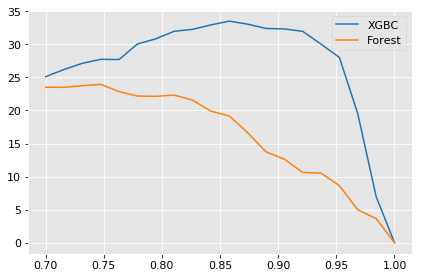

In [11]:
plt.plot(np.linspace(0.7,1,20), pred_XGBC, label='XGBC')
plt.plot(np.linspace(0.7,1,20), pred_Tree, label='Forest')
plt.legend()
plt.show()